Copyright (C) Microsoft Corporation.

# Transfer learning using Keras with CNTK backend and LightGBM

**Important**: Make sure the kernel is set to "Your project name myvm" which can be done from the *Kernel* menu under *Change kernel*.

In this notebook, you will be classifying the images you prepared in the first notebook into two categories using transfer learning. One major transfer learning scenario is to use a network that is pretrained on a large image dataset. Here, you will use a [Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) architecture called [ResNet50](https://arxiv.org/abs/1512.03385), pretrained on [ImageNet](https://en.wikipedia.org/wiki/ImageNet) dataset  which contains 1.2 million images with 1000 categories. You will first remove the last network layer to generate visual features of the images. You will then use these features to train a boosted decision tree to classify the images as pass or fail. You will use [Keras](https://keras.io/) with [Microsoft Cognitive Toolkit CNTK](https://github.com/Microsoft/cntk) backend for the CNN and [LightGBM](https://lightgbm.readthedocs.io/en/latest/) for binary classification. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import os
from os import path
from glob import iglob
from tqdm import tqdm
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import h5py

In [3]:
os.environ["KERAS_BACKEND"] = "cntk"
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

Using CNTK backend


In [4]:
from azureml.logging import get_azureml_logger
logger = get_azureml_logger()

## Prepare training features and labels

You will use the AZUREML_NATIVE_SHARE_DIRECTORY to save your intermediate results.

In [5]:
save_path = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']

First, read in the fail and pass images and check the number of images in each category. 

In [6]:
files_path = path.join(save_path, 'train')
fail_files = sorted(iglob(path.join(files_path, '*fail*.jpg')))
pass_files = sorted(iglob(path.join(files_path, '*pass*.jpg')))
print('Number of fail images: ' + str(len(fail_files)))
print('Number of pass images: ' + str(len(pass_files)))

Number of fail images: 12500
Number of pass images: 12500


### Generate labels

Next, prepare the labels of the images. You will be labeling fail images with 0 and pass images with 1.

In [7]:
image_paths = fail_files + pass_files
total_files = len(fail_files) + len(pass_files)
labels = np.zeros(total_files)
labels[len(fail_files):] = 1
labels

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

### Compute features

In this part, you will use ResNet50 model with weights pretrained on ImageNet to obtain the features of the images. Download the model and save it into a keras model object. The include_top=False parameter is required to indicate that you will not include the fully-connected layer at the top of the network since you will only use the network to featurize images. The default input image size for this model is (224, 244) with 3 color channnels and requires input_shape=(224, 224, 3) parameter to be set as 'channels_last'.

In [8]:
model = ResNet50(include_top=False, input_shape=(224, 224, 3))

92905472/94653016 [============================>.] - ETA: 0s

Next, you will use two helper functions, one for yielding batch size image paths from a list of file paths and the other one for  featurizing these batches of images.

In [9]:
def file_batch(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i + batch_size]

In [10]:
def featurize_images(file_list, model, batch_size=32):
    features = []
    
    for fb in tqdm(file_batch(file_list, batch_size)):
        load_img = []
        for file_path in fb:
            img = image.load_img(file_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            load_img.append(preprocess_input(x))
        features.extend(model.predict_on_batch(np.concatenate(load_img)).squeeze())
    return np.array(features)

The featurize_images function  processes the image files in small chunks (default is set to batch_size=32) by first loading the images in the batch into a target size of (224,224), then converting them into four dimensional tensors which keras model expects as input. After, that model's batch prediction method is called to calculate the features of each image.

Next, you will call the function to compute the features and save them into the share folder. The execution of the following cell may take up to 10-15 minutes so feel free to read through the links provided in the beginning of the notebook in order to learn more about CNNs, ResNet50, Keras, CNTK and LightGBM.

In [11]:
%%time
features_filename = path.join(save_path, 'features_resnet50.npy')
if path.isfile(features_filename):
    print("Features found!")
    features = np.load(features_filename)
else:
    print("Computing features")
    features = featurize_images(image_paths, model) 
    np.save(features_filename, features)

0it [00:00, ?it/s]

Computing features


782it [11:47,  1.10it/s]


CPU times: user 10min 8s, sys: 58.3 s, total: 11min 7s
Wall time: 11min 48s


Check the shape of the computed features.

In [12]:
features.shape

(25000, 2048)

## Training and Cross Validation

In this section, you will use the features calcuated in the previous section to train a LightGBM classifier. You will be performing cross validation to understand the performance of the model. You will use [scikit-learn's stratified K-fold cross validation](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.StratifiedKFold.html) where the folds are made by preserving the percentage of samples from each class. This is an important step especially if you are using your own data and number of images in one of the categories is substentially less than the other category. You will be using 5 fold cross validation. You can pick other values by changing n_splits in the next cell to the desired number of folds.

In [13]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=2048, shuffle=True)
cv_results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'Confusion Matrix'])

You will use a helper function called classification_metircs to calculate the evaluation metrics for each fold. 

In [14]:
def classification_metrics(y_true, y_pred_proba, threshold=0.5):
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    cm_dict = {}
    cm_dict['Accuracy'] = accuracy_score(y_true, y_pred)
    cm_dict['Precision'] =  precision_score(y_true, y_pred)
    cm_dict['Recall'] =  recall_score(y_true, y_pred)
    cm_dict['F1'] =  f1_score(y_true, y_pred) 
    cm_dict['AUC'] = roc_auc_score(y_true, y_pred_proba)
    cm_dict['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    return cm_dict

Next, provide parameters of the LightGBM model. You can experiment with different parameters.

In [15]:
params = {'num_leaves': 256,
           'learning_rate': 0.1,
           'min_split_gain': 0.1,
           'min_child_weight': 30,
           'reg_lambda': 1,
           'subsample': 1,
           'objective':'binary',
           'task': 'train',
           'verbose': 4
           }

Below, you will train your classifer for each fold and print the metrics.

In [16]:
%%time 
for train_index, test_index in tqdm(skf.split(features, labels)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    clf = lgb.train(params, lgb_train, num_boost_round=500)
    y_pred_proba = clf.predict(X_test)
    cm_dict = classification_metrics(y_test, y_pred_proba)
    print(cm_dict)
    cv_results = cv_results.append(classification_metrics(y_test, y_pred_proba),ignore_index=True)

1it [00:17, 17.65s/it]

{'Precision': 0.98685782556750301, 'Recall': 0.99119999999999997, 'F1': 0.9890241468768709, 'AUC': 0.99931535999999999, 'Accuracy': 0.98899999999999999, 'Confusion Matrix': [[2467, 33], [22, 2478]]}


2it [00:35, 17.87s/it]

{'Precision': 0.98374306106264864, 'Recall': 0.99239999999999995, 'F1': 0.98805256869772995, 'AUC': 0.99951455999999994, 'Accuracy': 0.98799999999999999, 'Confusion Matrix': [[2459, 41], [19, 2481]]}


3it [00:52, 17.58s/it]

{'Precision': 0.98445595854922274, 'Recall': 0.98799999999999999, 'F1': 0.98622479536833696, 'AUC': 0.99931712000000006, 'Accuracy': 0.98619999999999997, 'Confusion Matrix': [[2461, 39], [30, 2470]]}


4it [01:10, 17.69s/it]

{'Precision': 0.98447452229299359, 'Recall': 0.98919999999999997, 'F1': 0.98683160415003979, 'AUC': 0.9994075200000001, 'Accuracy': 0.98680000000000001, 'Confusion Matrix': [[2461, 39], [27, 2473]]}


5it [01:28, 17.76s/it]

{'Precision': 0.98758510212254702, 'Recall': 0.98640000000000005, 'F1': 0.98699219531719029, 'AUC': 0.99890223999999994, 'Accuracy': 0.98699999999999999, 'Confusion Matrix': [[2469, 31], [34, 2466]]}
CPU times: user 12min 19s, sys: 9.28 s, total: 12min 29s
Wall time: 1min 28s


In [17]:
cv_results.mean()

Accuracy     0.987400
Precision    0.985423
Recall       0.989440
F1           0.987425
AUC          0.999291
dtype: float64

Below, you will be using Azure Machine Learning Workbench's data collector to log the metrics of your cross validation. The metrics are stored by the history service and tied to the notebook that produced them. You can later view these metrics in the Run History tab of Azure ML Workbench. We will turn the cell level logging on before logging and turn it off after so that only the history of cell runs where metrics are collected are captured.

In [18]:
%azureml history on
%azureml history show

History logging enabled
History logging is enabled


In [19]:
logger.log('Accuracy',cv_results.mean()['Accuracy'])
logger.log('Precision',cv_results.mean()['Precision'])
logger.log('Recall',cv_results.mean()['Recall'])
logger.log('F1',cv_results.mean()['F1'])
logger.log('AUC',cv_results.mean()['AUC'])

In [20]:
%azureml history off

History logging disabled


Now, you will train our model on the whole dataset one last time to obtain the final trained model for operationalization. You will also plot the confusion matrix for this model.

In [21]:
lgb_train = lgb.Dataset(features, labels, free_raw_data=False)
clf = lgb.train(params, lgb_train, num_boost_round=500)
y_pred_proba = clf.predict(features)

You will use the following helper function to plot the confusion matrix.

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0: cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

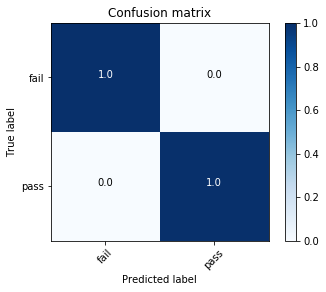

Confusion Matrix:
[[12497     3]
 [    0 12500]]


In [23]:
cm = np.asarray(classification_metrics(labels, y_pred_proba)['Confusion Matrix'])
plot_confusion_matrix(cm, ['fail','pass'], normalize=True)
print('Confusion Matrix:')
print(cm)

## Save the model

Save the model file to the shared folder. You will load this file in the next notebook for operationalization.

In [24]:
model_path = path.join(save_path,'lightgbm_classifier.model')
clf.save_model(model_path)

As one option to retrive your model for operationalization, you can  write the file to the special outputs folder which can be accessed from Azure ML workbench under the run history tab for this notebook. 

In [25]:
outputs = 'outputs'

In [26]:
model_path = path.join('outputs','lightgbm_classifier.model')
clf.save_model(model_path)

In [27]:
%azureml history on

History logging enabled


In [28]:
filepath = path.join('outputs','lightgbm_classifier.model')
with open(filepath, "rb") as file:
    get_azureml_logger().upload(path.normpath(filepath), file.read())

Now, as an option, you can locate the model file in Azure ML Workbench by clicking the last completed run under the notebook run history and download it.

In [29]:
%azureml history off

History logging disabled


As another option, you will create a folder under AZUREML_NATIVE_SHARE_DIRECTORY where you will save the files needed for operationalization. In the next notebook, you will compress and upload this folder to blob storage for later retrieval and usage for web service deployment.

In [43]:
o16n_path = path.join(save_path,'o16n')  
if not os.path.exists(o16n_path):
    os.makedirs(o16n_path)

In [45]:
model_path = path.join(o16n_path,'lightgbm_classifier.model')
clf.save_model(model_path)

Next, go to the 3rd notebook to prepare other files needed for operationalization of your model.